
# 🏏 Milestone–1: Cricket Data Ingestion, Cleaning & Initial EDA

## Objective
This notebook completes **Task‑1**, **Task‑2**, and starts **Task‑3** of the project.

### Tasks Covered
- **Task‑1:** Load and extract Kaggle YAML cricket dataset  
- **Task‑2:** Clean, normalize, handle outliers, and validate date formats  
- **Task‑3:** Initial EDA (Runs, Wickets, Venues, Team Performance)

Dataset format is **YAML-based (Cricsheet style)**.


## 📦 1. Imports & Configuration

In [1]:

import os
from pathlib import Path
import yaml
from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", None)
sns.set(style="whitegrid")

# CHANGE THIS PATH
DATA_ROOT = Path("D:\Ball_By_Ball Data")
PROCESSED_DIR = DATA_ROOT / "processed"
PROCESSED_DIR.mkdir(exist_ok=True)


## 📥 2. Task‑1: Dataset Loading (YAML → DataFrame)

In [2]:

LEAGUES = ["ipl"]

def list_yaml_files():
    files = []
    for league in LEAGUES:
        league_dir = DATA_ROOT / league
        if not league_dir.exists():
            continue
        for f in league_dir.rglob("*.yaml"):
            files.append((league, f))
    return files

yaml_files = list_yaml_files()
len(yaml_files)


1169

In [3]:

def load_yaml(path):
    with open(path, "r", encoding="utf-8") as f:
        return yaml.safe_load(f)


In [7]:
def parse_match(league, path):
    raw = load_yaml(path)
    info = raw.get("info", {})

    # Date extraction (robust)
    if "dates" in info:
        match_date = info["dates"][0]
    elif "date" in info:
        match_date = info["date"]
    elif "event" in info and "start_date" in info["event"]:
        match_date = info["event"]["start_date"]
    else:
        match_date = None

    venue = info.get("venue")

    rows = []

    for innings_idx, innings in enumerate(raw.get("innings", []), start=1):
        innings_name, innings_data = list(innings.items())[0]
        batting_team = innings_data.get("team")

        for delivery in innings_data.get("deliveries", []):
            ball_no, ball = list(delivery.items())[0]

            runs = ball.get("runs", {})
            wickets = ball.get("wicket")

            rows.append({
                "league": league,
                "match_id": path.stem,
                "match_date_raw": match_date,
                "venue": venue,
                "innings": innings_idx,
                "ball": ball_no,

                "batting_team": batting_team,
                "batter": ball.get("batsman"),
                "bowler": ball.get("bowler"),

                "runs_batter": runs.get("batsman", 0),
                "runs_extras": runs.get("extras", 0),
                "runs_total": runs.get("total", 0),

                "wicket": 1 if wickets else 0
            })

    return rows


In [8]:
all_rows = []
for league, path in tqdm(yaml_files):
    all_rows.extend(parse_match(league, path))

deliveries_df = pd.DataFrame(all_rows)
deliveries_df.head()


100%|██████████| 1169/1169 [02:57<00:00,  6.57it/s]


,league,match_id,match_date_raw,venue,innings,ball,batting_team,batter,bowler,runs_batter,runs_extras,runs_total,wicket
0,ipl,1082591,2017-04-05,"Rajiv Gandhi International Stadium, Uppal",1,0.1,Sunrisers Hyderabad,DA Warner,TS Mills,0,0,0,0
1,ipl,1082591,2017-04-05,"Rajiv Gandhi International Stadium, Uppal",1,0.2,Sunrisers Hyderabad,DA Warner,TS Mills,0,0,0,0
2,ipl,1082591,2017-04-05,"Rajiv Gandhi International Stadium, Uppal",1,0.3,Sunrisers Hyderabad,DA Warner,TS Mills,4,0,4,0
3,ipl,1082591,2017-04-05,"Rajiv Gandhi International Stadium, Uppal",1,0.4,Sunrisers Hyderabad,DA Warner,TS Mills,0,0,0,0
4,ipl,1082591,2017-04-05,"Rajiv Gandhi International Stadium, Uppal",1,0.5,Sunrisers Hyderabad,DA Warner,TS Mills,0,2,2,0


## 🧹 3. Task‑2: Data Cleaning & Normalization

In [9]:
df = deliveries_df.copy()

df["match_date"] = pd.to_datetime(df["match_date_raw"], errors="coerce")

num_cols = ["runs_batter", "runs_extras", "runs_total", "innings", "wicket"]
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

df["venue"] = df["venue"].fillna("Unknown")

df = df.dropna(subset=["batting_team", "batter", "bowler"])

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278205 entries, 0 to 278204
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   league          278205 non-null  object        
 1   match_id        278205 non-null  object        
 2   match_date_raw  278205 non-null  object        
 3   venue           278205 non-null  object        
 4   innings         278205 non-null  int64         
 5   ball            278205 non-null  float64       
 6   batting_team    278205 non-null  object        
 7   batter          278205 non-null  object        
 8   bowler          278205 non-null  object        
 9   runs_batter     278205 non-null  int64         
 10  runs_extras     278205 non-null  int64         
 11  runs_total      278205 non-null  int64         
 12  wicket          278205 non-null  int64         
 13  match_date      278205 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), in

In [10]:

# Outlier flag using IQR on runs
Q1 = df["runs_total"].quantile(0.25)
Q3 = df["runs_total"].quantile(0.75)
IQR = Q3 - Q1
upper = Q3 + 1.5 * IQR

df["is_runs_outlier"] = df["runs_total"] > upper
df["is_runs_outlier"].value_counts()


is_runs_outlier
False    229838
True      48367
Name: count, dtype: int64

## 📊 4. Task‑3: Initial Exploratory Data Analysis

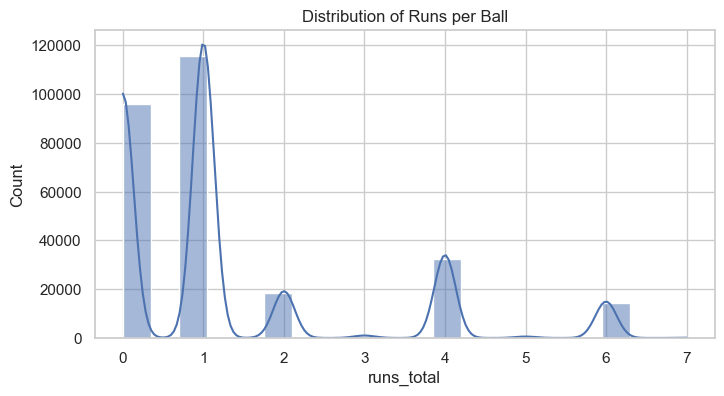

In [11]:

# Runs distribution
plt.figure(figsize=(8,4))
sns.histplot(df["runs_total"], bins=20, kde=True)
plt.title("Distribution of Runs per Ball")
plt.show()


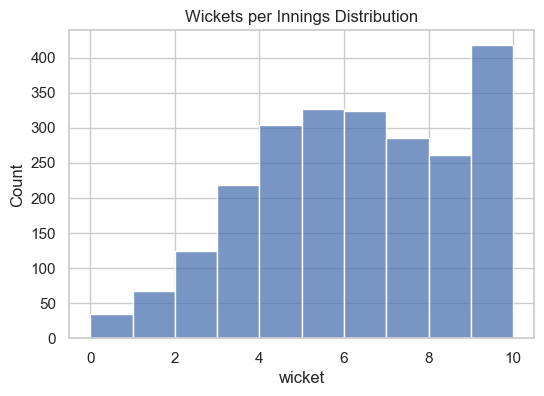

In [12]:

# Wickets per innings
wickets_per_innings = df.groupby(["match_id", "innings"])["wicket"].sum()

plt.figure(figsize=(6,4))
sns.histplot(wickets_per_innings, bins=10)
plt.title("Wickets per Innings Distribution")
plt.show()


In [13]:

# Venue statistics
venue_stats = df.groupby("venue").agg(
    matches=("match_id", "nunique"),
    avg_runs=("runs_total", "mean"),
    wickets=("wicket", "sum")
).query("matches >= 10").sort_values("avg_runs", ascending=False)

venue_stats.head()


,matches,avg_runs,wickets
venue,,,
"Eden Gardens, Kolkata",23,1.572320,271
"Arun Jaitley Stadium, Delhi",23,1.553543,278
"Rajiv Gandhi International Stadium, Uppal, Hyderabad",19,1.544147,207
"M Chinnaswamy Stadium, Bengaluru",19,1.540778,238
"Sawai Mansingh Stadium, Jaipur",17,1.507171,172


In [14]:

# Team performance
team_perf = df.groupby("batting_team").agg(
    matches=("match_id", "nunique"),
    avg_runs=("runs_total", "mean"),
    wickets_lost=("wicket", "sum")
).sort_values("avg_runs", ascending=False)

team_perf.head()


,matches,avg_runs,wickets_lost
batting_team,,,
Royal Challengers Bengaluru,30,1.581138,181
Gujarat Titans,60,1.452599,325
Punjab Kings,74,1.443655,474
Lucknow Super Giants,58,1.433651,358
Delhi Capitals,105,1.379310,658



## ✅ Milestone‑1 Completed

✔ Task‑1: YAML ingestion complete  
✔ Task‑2: Cleaning, normalization, outlier detection done  
✔ Task‑3: Initial EDA completed  

Next Milestone → Feature Engineering & ML Models
